In [1]:
import GamificationRL
from collections import defaultdict
import gymnasium as gym
from GamificationRL.envs.gamification_elements import *
import random
from itertools import permutations  
from adaptive_agent import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from hexad_answer_bot import *
plt.rcParams["figure.figsize"]=(10,7)
import pandas as pd
hexad_types_full = ["Player", "Achiever", "Philanthropist", "Disruptor", "Socializer", "Free Spirit"]
import logging
gym.logger.setLevel(logging.CRITICAL)

#### Environment Init

In [2]:
corr_g_e=list(corr_gamification_elements.values())
sample_g_e=list(sample_gamification_elements.values())
g_e=sample_g_e[1::2]
colors=['violet','purple','red','sienna',
        'darkorange','burlywood','gold','darkgoldenrod',
        'olivedrab','lawngreen','deepskyblue','steelblue']
ge2c={"Nothing":'black'}
for i in range(len(g_e)):
    ge2c[g_e[i].name]=colors[i]
hexad=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict
#hexad=hexad_load_dict(pl=3,ach=3,ph=3,dis=3,s=3,fs=3).load_dict
fatigue_penalty=0.05
fatigue_replenishment=0.01
nothing_reward=75
ranges=(1.0,1.3,1.7)
increase=(0.2,0.1,0.05)
decrease=(0.1,0.1,0.1)
pref_min=0.2
seed=10101

In [3]:
env = gym.make('GamificationRL/GamificationPreferenceEnv-v0',
               hexad_load=hexad,
               gamification_elements=g_e,
               use_fatigue=True,
               individual_modifications=None,
               repetition_penalty=(400,800),
               nothing_reward=nothing_reward,
               fatigue_reduction=fatigue_penalty,
               fatigue_replenish=fatigue_replenishment,
               pref_ranges=ranges,
               pref_increase=increase,
               pref_decrease=decrease,
               pref_min=pref_min,
               seed=seed
               )
obs,_=env.reset()

#### Answer Bot Init

In [4]:
uncertainty=.1
divisor=5.5
starting_threshold=.1
gain_modifier=0.02
amount=1
ht=copy.deepcopy(hexad)
#ht=hexad_load_dict(pl=2,ach=5,ph=4,dis=0.5,s=1,fs=3).load_dict

In [5]:
bot = ScoreChangeBot(
        hexad_types=copy.deepcopy(ht),
        uncertainty= uncertainty,
        divisor=divisor,
        starting_change_threshold=starting_threshold,
        change_gain_modifier=gain_modifier,
        change_amount=amount,
        seed=seed,
    )

#### Agent init

In [6]:
#general parameters
learn_rate=0.002
discount_factor=0.7

In [7]:
#Fatigue-aware parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(10000)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [8]:
fa_agent=FatigueAwareAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )
train_error=fa_agent.train(env=env,iterations=training_iterations,trunc_error=True)

In [9]:
#Epsilon agent parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(10000)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*3/4000)

In [10]:
e_agent=EpsilonAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   )
train_error=e_agent.train(env=env,iterations=training_iterations,trunc_error=True)

In [11]:

basic_agent=BasicAGAgent(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   )
train_error=basic_agent.train(env=env,iterations=training_iterations,trunc_error=True)


In [12]:
#RandomBestOfX parameters
epsilon=1
epsilon_min=0.1
#training_iterations=int(1e6)
training_iterations=int(10000)
epsilon_decay=(epsilon-epsilon_min)/(training_iterations*4/5000)
x=3

In [13]:

boX_agent=RandomBestOfX(learn_rate=learn_rate,
                   discount_factor=discount_factor,
                   env=env,
                   epsilon=epsilon,
                   epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min,
                   X=x
                   )

train_error=boX_agent.train(env=env,iterations=training_iterations,trunc_error=True)


In [14]:
agents={"Basic":basic_agent,"Epsilon":e_agent,"BestOfX":boX_agent,"FatigueAware":fa_agent}
init_q_values={}
for name,agent in agents.items():
    init_q_values[name]=copy.deepcopy(agent.q_values)

#### Testing Functions

In [15]:
import time
def test_env_agent(env,agent,answer_bot,test_iterations,retrain_iterations,random_retrain,training_lr):
    rewards=[]
    choices=[]
    best=[]
    agent_error=[]
    actions=defaultdict(lambda:{'x':[],'y':[]})
    obs,info=env.reset()
    for i in tqdm(range(test_iterations),miniters=int(test_iterations/50)):
        best.append(env.get_best_action())
        act=agent.get_action(obs,avoid_reps=True)
        h_type=env.ge[env.action_to_ge[act]].type
        answer,_=answer_bot.get_answer(h_type)
        choice,reward,new_obs,info,error=agent\
            .step_and_update(env=env,
                            obs=obs,
                            answer=answer,
                            retrain_iterations=retrain_iterations,
                            learning_rate=training_lr,
                            random_retrain=random_retrain,
                            act=act)
        choices.append(choice)
        rewards.append(reward)
        agent_error.append(error)
        actions[choice]['x'].append(i)
        actions[choice]['y'].append(reward)
        obs=new_obs
    return rewards,choices,best,agent_error,actions,(obs,info)

In [16]:
def plot_actions(actions,env,title=None,f=1):
    typ='pl'
    fig=plt.figure(f,figsize=(12,7))
    fig.suptitle(title)
    for i,_ in sorted(actions.items()):
        name=env.action_to_ge[i]
        hex_type=env.ge[name].type
        if hex_type!=None:
            plt.figure(f)
            type_index=hexad_types.index(env.ge[name].type)+1
        else:
            plt.figure(f+1)
        plt.subplot(3,2,type_index)
        plt.ylim(0,1000)
        plt.xlim(0,1000)
        plt.scatter(actions[i]['x'],actions[i]['y'],label=name,s=2)
        ax=plt.gca()
        ax.legend()
    plt.figure(f+2)
    fig.suptitle(title)
    for i in actions:
        plt.scatter(actions[i]['x'],actions[i]['y'],label=env.action_to_ge[i],s=5)
        ax=plt.gca()
        ax.legend()

In [17]:
def get_stats(actions,best,choices):
    type_stats=defaultdict(lambda:0)
    for i in actions:
        try:
            type_stats[sample_gamification_elements[env.action_to_ge[i]].type]+=len(actions[i]['x'])
        except KeyError:
            type_stats['None']+=len(actions[i]['x'])
    s=0
    for i in range(len(best)):
        if best[i][1]==choices[i][1]:
            s+=1
    diff=[best[i][1]-choices[i][1] for i in range(len(choices))]
    diff=np.array(diff)
    diff=diff[diff>0.01]
    actual=pd.Series([env.action_to_ge[item[0]] for item in best],name="Actual Best")
    pred = pd.Series([env.action_to_ge[item[0]] for item in b],name="Predicted Best")
    conf_matrix=pd.crosstab(actual,pred,margins=True)
    return type_stats,s/len(best),diff,conf_matrix

#### Hyperparameter tuning

##### Retrains per iteration

In [18]:
tests=500
retrains=1000
retrain_learn_rate=0.3
accs={}
a_e={}
d_b={}
times={}
j=0
test_range = [1,100,250,500,750,1000,1500,2000,4000]
for name,agent in agents.items():
    print(name)
    random_retrain=(name=="Basic" or name=='BestOfX')
    accs[name]={'avg':[],'std':[]}
    a_e[name]={'avg':[],'std':[]}
    d_b[name]={'avg':[],'std':[]}
    times[name]={'avg':[],'std':[]}
    for retrains in tqdm(test_range):
        print(f"Current test: retrains={retrains}")
        print("Iteration: ",end='')
        accuracy=[]
        diff_from_best=[]
        agent_error=[]
        exe_time=[]
        for j in range(4):
            print(f"{j+1}, ",end='')
            start_time=time.time_ns()
            r,c,b,e,a,_=test_env_agent(env,agent,
                        answer_bot=bot,
                        test_iterations=tests,
                        retrain_iterations=retrains,
                        random_retrain=random_retrain,
                        training_lr=retrain_learn_rate)
            end_time=time.time_ns()
            elapsed=start_time-end_time
            exe_time.append(elapsed)
            t,acc,diff,conf_matrix = get_stats(a,b,[*zip(c,r)])
            accuracy.append(acc)
            diff_from_best.extend((diff))
            agent_error.extend((e))
            agent.reset()
            agent.train(env=env,iterations=training_iterations,trunc_error=True)
            bot = ScoreChangeBot(
                hexad_types=ht,
                uncertainty= uncertainty,
                divisor=divisor,
                starting_change_threshold=starting_threshold,
                change_gain_modifier=gain_modifier,
                change_amount=amount,
                seed=seed,
            )
        print()  
        accs[name]['avg'].append(np.average(accuracy))
        accs[name]['std'].append(np.std(accuracy))
        a_e[name]['avg'].append(np.average(agent_error))
        a_e[name]['std'].append(np.std(agent_error))
        d_b[name]['avg'].append(np.average(diff_from_best))
        d_b[name]['std'].append(np.std(diff_from_best))
        times[name]['avg'].append(np.average(exe_time))
        times[name]['std'].append(np.std(exe_time))

Basic


  0%|          | 0/9 [00:00<?, ?it/s]

Current test: retrains=1
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 7576.09it/s]


2, 

100%|██████████| 500/500 [00:00<00:00, 7353.42it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 3546.10it/s]


4, 

 11%|█         | 1/9 [00:01<00:11,  1.48s/it]


Current test: retrains=100
Iteration: 1, 

100%|██████████| 500/500 [00:01<00:00, 406.17it/s]


2, 

100%|██████████| 500/500 [00:01<00:00, 341.76it/s]


3, 

100%|██████████| 500/500 [00:01<00:00, 399.36it/s]


4, 

 22%|██▏       | 2/9 [00:07<00:30,  4.32s/it]


Current test: retrains=250
Iteration: 1, 

100%|██████████| 500/500 [00:03<00:00, 164.15it/s]


2, 

100%|██████████| 500/500 [00:02<00:00, 169.26it/s]


3, 

100%|██████████| 500/500 [00:03<00:00, 152.44it/s]


4, 

 33%|███▎      | 3/9 [00:21<00:51,  8.62s/it]


Current test: retrains=500
Iteration: 1, 

100%|██████████| 500/500 [00:06<00:00, 78.22it/s]


2, 

100%|██████████| 500/500 [00:06<00:00, 83.26it/s]


3, 

100%|██████████| 500/500 [00:06<00:00, 78.59it/s]


4, 

 44%|████▍     | 4/9 [00:47<01:16, 15.39s/it]


Current test: retrains=750
Iteration: 1, 

100%|██████████| 500/500 [00:09<00:00, 54.35it/s]


2, 

100%|██████████| 500/500 [00:09<00:00, 51.45it/s]


3, 

100%|██████████| 500/500 [00:10<00:00, 48.98it/s]


4, 

 56%|█████▌    | 5/9 [01:26<01:36, 24.15s/it]


Current test: retrains=1000
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 43.06it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 44.95it/s]


3, 

100%|██████████| 500/500 [00:11<00:00, 42.87it/s]


4, 

 67%|██████▋   | 6/9 [02:13<01:35, 31.88s/it]


Current test: retrains=1500
Iteration: 1, 

100%|██████████| 500/500 [00:17<00:00, 28.49it/s]


2, 

100%|██████████| 500/500 [00:16<00:00, 30.04it/s]


3, 

100%|██████████| 500/500 [00:18<00:00, 27.44it/s]


4, 

 78%|███████▊  | 7/9 [03:24<01:29, 44.64s/it]


Current test: retrains=2000
Iteration: 1, 

100%|██████████| 500/500 [00:23<00:00, 21.36it/s]


2, 

100%|██████████| 500/500 [00:23<00:00, 21.22it/s]


3, 

100%|██████████| 500/500 [00:22<00:00, 21.84it/s]


4, 

 89%|████████▉ | 8/9 [04:59<01:00, 60.52s/it]


Current test: retrains=4000
Iteration: 1, 

100%|██████████| 500/500 [00:49<00:00, 10.13it/s]


2, 

100%|██████████| 500/500 [00:47<00:00, 10.54it/s]


3, 

100%|██████████| 500/500 [00:44<00:00, 11.26it/s]


4, 

100%|██████████| 9/9 [08:07<00:00, 54.22s/it] 



Epsilon


  0%|          | 0/9 [00:00<?, ?it/s]

Current test: retrains=1
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 6410.33it/s]


2, 

100%|██████████| 500/500 [00:00<00:00, 7692.72it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 6944.30it/s]


4, 

 11%|█         | 1/9 [00:01<00:11,  1.38s/it]


Current test: retrains=100
Iteration: 1, 

100%|██████████| 500/500 [00:01<00:00, 315.46it/s]


2, 

100%|██████████| 500/500 [00:01<00:00, 292.23it/s]


3, 

100%|██████████| 500/500 [00:01<00:00, 335.57it/s]


4, 

 22%|██▏       | 2/9 [00:09<00:35,  5.07s/it]


Current test: retrains=250
Iteration: 1, 

100%|██████████| 500/500 [00:03<00:00, 135.03it/s]


2, 

100%|██████████| 500/500 [00:03<00:00, 127.58it/s]


3, 

100%|██████████| 500/500 [00:03<00:00, 130.24it/s]


4, 

 33%|███▎      | 3/9 [00:25<01:00, 10.14s/it]


Current test: retrains=500
Iteration: 1, 

100%|██████████| 500/500 [00:07<00:00, 67.68it/s]


2, 

100%|██████████| 500/500 [00:08<00:00, 61.37it/s]


3, 

100%|██████████| 500/500 [00:08<00:00, 57.47it/s]


4, 

 44%|████▍     | 4/9 [00:58<01:35, 19.08s/it]


Current test: retrains=750
Iteration: 1, 

100%|██████████| 500/500 [00:11<00:00, 45.34it/s]


2, 

100%|██████████| 500/500 [00:11<00:00, 42.83it/s]


3, 

100%|██████████| 500/500 [00:10<00:00, 46.64it/s]


4, 

 56%|█████▌    | 5/9 [01:43<01:55, 28.76s/it]


Current test: retrains=1000
Iteration: 1, 

100%|██████████| 500/500 [00:16<00:00, 30.35it/s]


2, 

100%|██████████| 500/500 [00:14<00:00, 33.74it/s]


3, 

100%|██████████| 500/500 [00:11<00:00, 42.08it/s]


4, 

 67%|██████▋   | 6/9 [02:40<01:54, 38.13s/it]


Current test: retrains=1500
Iteration: 1, 

100%|██████████| 500/500 [00:18<00:00, 26.74it/s]


2, 

100%|██████████| 500/500 [00:18<00:00, 26.62it/s]


3, 

100%|██████████| 500/500 [00:18<00:00, 27.63it/s]


4, 

 78%|███████▊  | 7/9 [03:54<01:39, 49.98s/it]


Current test: retrains=2000
Iteration: 1, 

100%|██████████| 500/500 [00:24<00:00, 20.38it/s]


2, 

100%|██████████| 500/500 [00:24<00:00, 20.74it/s]


3, 

100%|██████████| 500/500 [00:24<00:00, 20.72it/s]


4, 

 89%|████████▉ | 8/9 [05:34<01:05, 65.75s/it]


Current test: retrains=4000
Iteration: 1, 

100%|██████████| 500/500 [00:47<00:00, 10.57it/s]


2, 

100%|██████████| 500/500 [00:47<00:00, 10.53it/s]


3, 

100%|██████████| 500/500 [00:47<00:00, 10.60it/s]


4, 

100%|██████████| 9/9 [08:45<00:00, 58.34s/it] 



BestOfX


  0%|          | 0/9 [00:00<?, ?it/s]

Current test: retrains=1
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 6173.18it/s]


2, 

100%|██████████| 500/500 [00:00<00:00, 7246.53it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 8620.78it/s]


4, 

 11%|█         | 1/9 [00:01<00:10,  1.32s/it]


Current test: retrains=100
Iteration: 1, 

100%|██████████| 500/500 [00:01<00:00, 417.01it/s]


2, 

100%|██████████| 500/500 [00:01<00:00, 432.15it/s]


3, 

100%|██████████| 500/500 [00:01<00:00, 429.55it/s]


4, 

 22%|██▏       | 2/9 [00:07<00:27,  3.92s/it]


Current test: retrains=250
Iteration: 1, 

100%|██████████| 500/500 [00:02<00:00, 189.32it/s]


2, 

100%|██████████| 500/500 [00:02<00:00, 183.15it/s]


3, 

100%|██████████| 500/500 [00:02<00:00, 184.09it/s]


4, 

 33%|███▎      | 3/9 [00:19<00:45,  7.60s/it]


Current test: retrains=500
Iteration: 1, 

100%|██████████| 500/500 [00:05<00:00, 87.63it/s]


2, 

100%|██████████| 500/500 [00:05<00:00, 94.08it/s]


3, 

100%|██████████| 500/500 [00:05<00:00, 84.05it/s]


4, 

 44%|████▍     | 4/9 [00:42<01:09, 13.85s/it]


Current test: retrains=750
Iteration: 1, 

100%|██████████| 500/500 [00:08<00:00, 61.66it/s]


2, 

100%|██████████| 500/500 [00:08<00:00, 62.44it/s]


3, 

100%|██████████| 500/500 [00:08<00:00, 61.32it/s]


4, 

 56%|█████▌    | 5/9 [01:17<01:25, 21.43s/it]


Current test: retrains=1000
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 41.19it/s]


2, 

100%|██████████| 500/500 [00:10<00:00, 47.38it/s]


3, 

100%|██████████| 500/500 [00:10<00:00, 49.36it/s]


4, 

 67%|██████▋   | 6/9 [02:01<01:27, 29.16s/it]


Current test: retrains=1500
Iteration: 1, 

100%|██████████| 500/500 [00:15<00:00, 32.95it/s]


2, 

100%|██████████| 500/500 [00:15<00:00, 32.82it/s]


3, 

100%|██████████| 500/500 [00:15<00:00, 33.01it/s]


4, 

 78%|███████▊  | 7/9 [03:02<01:19, 39.72s/it]


Current test: retrains=2000
Iteration: 1, 

100%|██████████| 500/500 [00:20<00:00, 24.90it/s]


2, 

100%|██████████| 500/500 [00:19<00:00, 25.13it/s]


3, 

100%|██████████| 500/500 [00:20<00:00, 25.00it/s]


4, 

 89%|████████▉ | 8/9 [04:25<00:53, 53.34s/it]


Current test: retrains=4000
Iteration: 1, 

100%|██████████| 500/500 [00:40<00:00, 12.49it/s]


2, 

100%|██████████| 500/500 [00:39<00:00, 12.63it/s]


3, 

100%|██████████| 500/500 [00:39<00:00, 12.81it/s]


4, 

100%|██████████| 9/9 [07:05<00:00, 47.30s/it]



FatigueAware


  0%|          | 0/9 [00:00<?, ?it/s]

Current test: retrains=1
Iteration: 1, 

100%|██████████| 500/500 [00:00<00:00, 5319.32it/s]


2, 

100%|██████████| 500/500 [00:00<00:00, 8196.23it/s]


3, 

100%|██████████| 500/500 [00:00<00:00, 7936.81it/s]


4, 

 11%|█         | 1/9 [00:01<00:11,  1.39s/it]


Current test: retrains=100
Iteration: 1, 

100%|██████████| 500/500 [00:01<00:00, 345.54it/s]


2, 

100%|██████████| 500/500 [00:01<00:00, 364.43it/s]


3, 

100%|██████████| 500/500 [00:01<00:00, 364.43it/s]


4, 

 22%|██▏       | 2/9 [00:08<00:31,  4.51s/it]


Current test: retrains=250
Iteration: 1, 

100%|██████████| 500/500 [00:03<00:00, 139.70it/s]


2, 

100%|██████████| 500/500 [00:03<00:00, 146.79it/s]


3, 

100%|██████████| 500/500 [00:03<00:00, 149.27it/s]


4, 

 33%|███▎      | 3/9 [00:22<00:55,  9.20s/it]


Current test: retrains=500
Iteration: 1, 

100%|██████████| 500/500 [00:06<00:00, 73.24it/s]


2, 

100%|██████████| 500/500 [00:06<00:00, 75.23it/s]


3, 

100%|██████████| 500/500 [00:06<00:00, 75.28it/s]


4, 

 44%|████▍     | 4/9 [00:50<01:22, 16.52s/it]


Current test: retrains=750
Iteration: 1, 

100%|██████████| 500/500 [00:09<00:00, 50.88it/s]


2, 

100%|██████████| 500/500 [00:09<00:00, 52.16it/s]


3, 

100%|██████████| 500/500 [00:09<00:00, 52.18it/s]


4, 

 56%|█████▌    | 5/9 [01:30<01:39, 25.00s/it]


Current test: retrains=1000
Iteration: 1, 

100%|██████████| 500/500 [00:12<00:00, 39.92it/s]


2, 

100%|██████████| 500/500 [00:12<00:00, 39.14it/s]


3, 

100%|██████████| 500/500 [00:12<00:00, 38.62it/s]


4, 

 67%|██████▋   | 6/9 [02:22<01:42, 34.20s/it]


Current test: retrains=1500
Iteration: 1, 

100%|██████████| 500/500 [00:18<00:00, 26.57it/s]


2, 

100%|██████████| 500/500 [00:18<00:00, 26.54it/s]


3, 

100%|██████████| 500/500 [00:18<00:00, 26.90it/s]


4, 

 78%|███████▊  | 7/9 [03:38<01:35, 47.96s/it]


Current test: retrains=2000
Iteration: 1, 

100%|██████████| 500/500 [00:24<00:00, 20.15it/s]


2, 

100%|██████████| 500/500 [00:24<00:00, 20.07it/s]


3, 

100%|██████████| 500/500 [00:24<00:00, 20.19it/s]


4, 

 89%|████████▉ | 8/9 [05:19<01:04, 64.77s/it]


Current test: retrains=4000
Iteration: 1, 

100%|██████████| 500/500 [00:48<00:00, 10.21it/s]


2, 

100%|██████████| 500/500 [00:49<00:00, 10.07it/s]


3, 

100%|██████████| 500/500 [00:55<00:00,  9.00it/s]


4, 

100%|██████████| 9/9 [08:46<00:00, 58.49s/it] 

In [57]:
t=np.array(times['Basic']['avg'])
(-t/1000000000)

array([ 0.09199322,  1.27899787,  3.15824795,  6.1495008 ,  9.63842778,
       11.4423865 , 17.42130415, 23.2842522 , 46.8799056 ])

Text(0.5, 1.0, 'Χρόνος επανεκπαίδευσης δράστη ως προς\nεπαναλήψεις επανεκπαίδευσης που εκτελούνται')

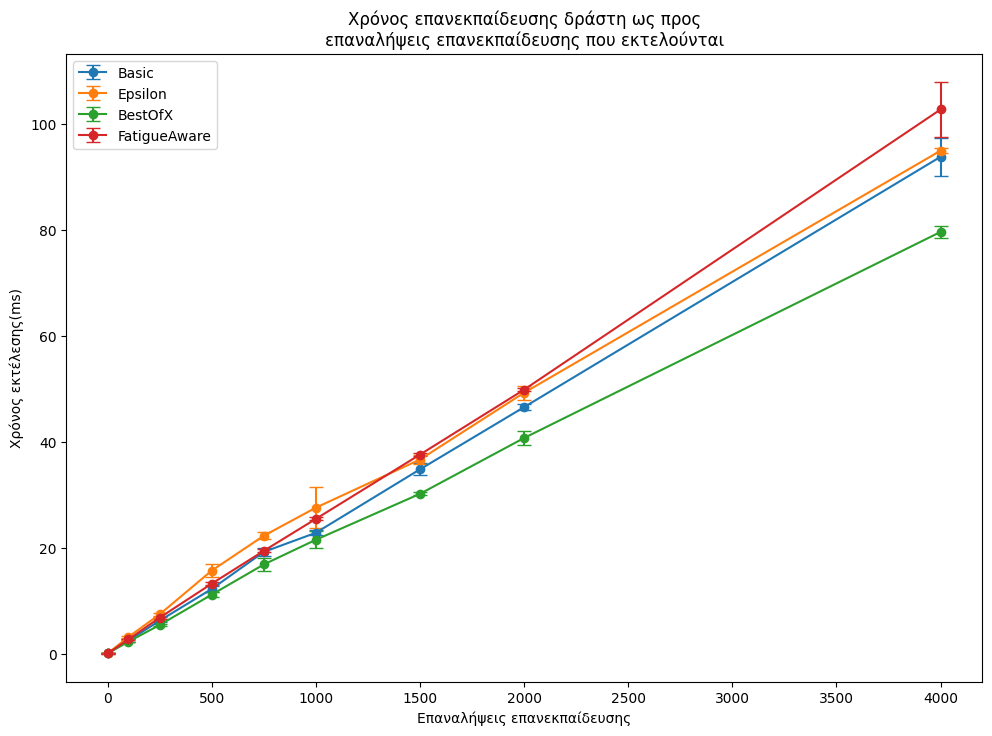

In [64]:
i=1
for name,agent in agents.items():
    plt.figure(1)
    av=np.array(times[name]['avg'])
    av=-av/500
    av=av/(1000000)
    sd=np.array(times[name]['std'])/500
    sd=sd/(1000000)
    plt.errorbar(test_range,av,sd,label=name,marker='o',capsize=5)
    plt.tight_layout(pad=1)
    if i in [1,3]:
        plt.ylabel('Χρόνος εκτέλεσης(ms)')
    if i in [3,4]:
        plt.xlabel('Επαναλήψεις επανεκπαίδευσης')
    i+=1
plt.legend()
plt.title("Χρόνος επανεκπαίδευσης δράστη ως προς\nεπαναλήψεις επανεκπαίδευσης που εκτελούνται")

In [19]:
acc_diff={}
for name,agent in agents.items():
    acc_diff[name]=[]
    a_d=[]
    prev=0
    for acc in accs[name]['avg']:
        acc_diff[name].append(acc-prev)
        prev=acc

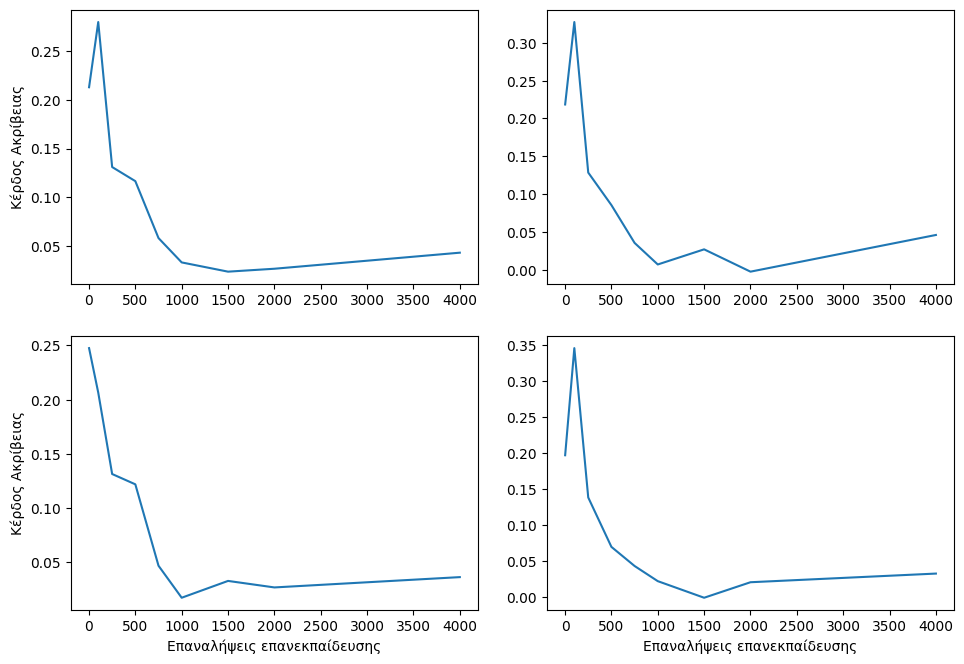

In [20]:
i=1
for name,agent in agents.items():
    plt.figure(1)
    plt.subplot(2,2,i)
    plt.plot(test_range,acc_diff[name])
    plt.tight_layout(pad=2)
    if i in [1,3]:
        plt.ylabel('Κέρδος Ακρίβειας')
    if i in [3,4]:
        plt.xlabel('Επαναλήψεις επανεκπαίδευσης')
    i+=1

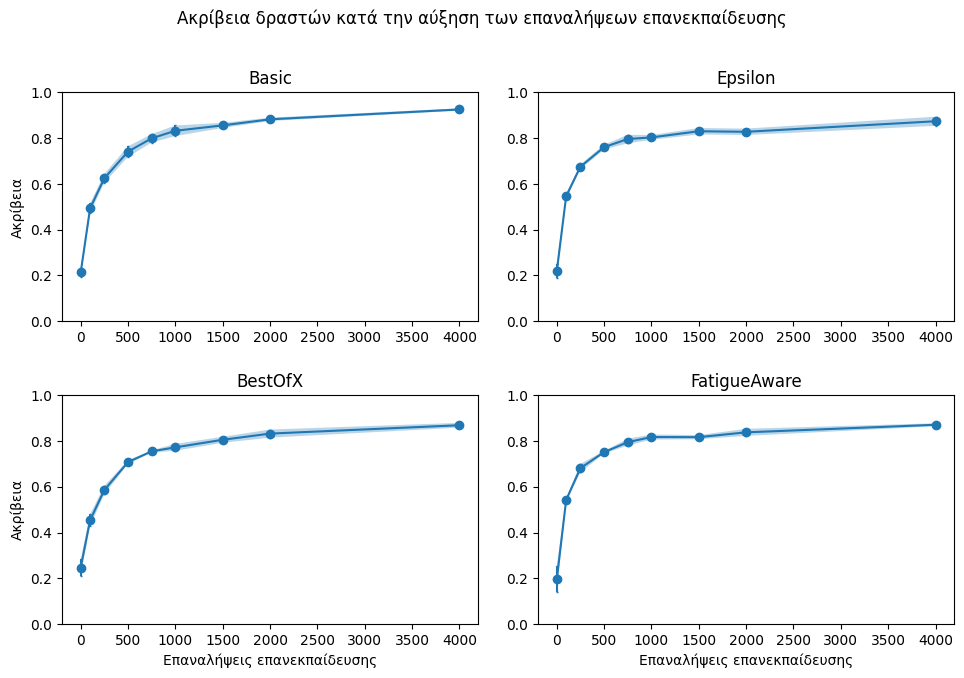

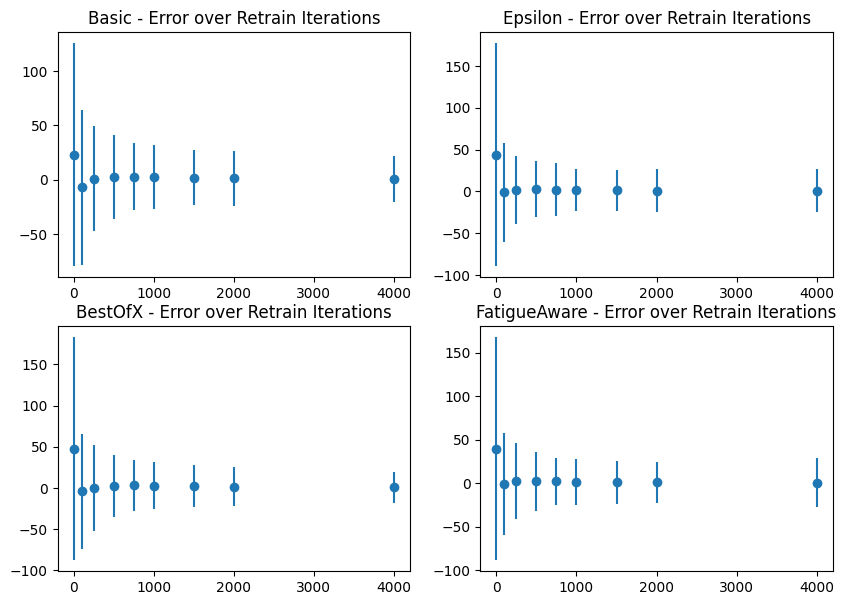

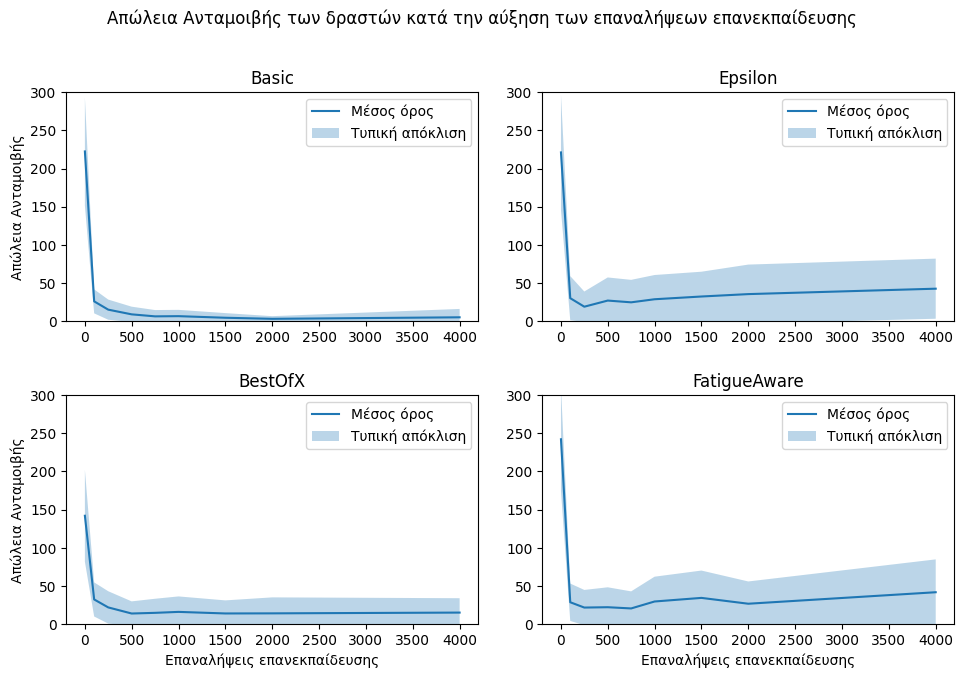

In [21]:
i=1
for name,agent in agents.items():
    plt.figure(1)
    plt.subplot(2,2,i)
    plt.errorbar(test_range,accs[name]['avg'],accs[name]['std'],marker='o',capsize=1)
    plt.fill_between(test_range,np.array(accs[name]['avg'])-np.array(accs[name]['std']),np.array(accs[name]['avg'])+np.array(accs[name]['std']),alpha=0.3)
    plt.tight_layout(pad=2)
    plt.ylim(0,1)
    if i in [1,3]:
        plt.ylabel('Ακρίβεια')
    if i in [3,4]:
        plt.xlabel('Επαναλήψεις επανεκπαίδευσης')
    plt.title("{}".format(name))
    plt.suptitle("Ακρίβεια δραστών κατά την αύξηση των επαναλήψεων επανεκπαίδευσης")
    plt.figure(2)
    plt.subplot(2,2,i)
    plt.errorbar(test_range,a_e[name]['avg'],a_e[name]['std'],marker='o',linestyle='')
    plt.title("{} - Error over Retrain Iterations".format(name))
    plt.figure(3)
    plt.subplot(2,2,i)
    y=np.array(d_b[name]['avg'])
    y_error=np.array(d_b[name]['std'])
    plt.plot(test_range,y,label='Μέσος όρος')
    plt.fill_between(test_range,y-y_error/2,y+y_error/2,alpha=0.3,label='Τυπική απόκλιση')
    plt.legend()
    plt.title("{}".format(name))
    plt.tight_layout(pad=2)
    plt.ylim(0,300)
    if i in [1,3]:
        plt.ylabel('Απώλεια Ανταμοιβής')
    if i in [3,4]:
        plt.xlabel('Επαναλήψεις επανεκπαίδευσης')
    plt.suptitle("Απώλεια Ανταμοιβής των δραστών κατά την αύξηση των επαναλήψεων επανεκπαίδευσης")
    i+=1